In [5]:
# Exploratory Data Analysis
# Author: Anam Ayyub
# Block 1: Imports and basic setup

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid", context="notebook")

# File paths
DATASET_PATH = r"../Dataset/DERM7PT"
META_DIR = os.path.join(DATASET_PATH, "meta")
META_FILE = os.path.join(META_DIR, "meta.csv")

# Output file names
CLEAN_FILE = os.path.join(META_DIR, "features.csv")
Y_BINARY_FILE = os.path.join(META_DIR, "target_binary.csv")
Y_MULTI_FILE = os.path.join(META_DIR, "target_multiclass.csv")
MISSING_FILE = os.path.join(META_DIR, "missing_report.csv")
SUMMARY_FILE = os.path.join(META_DIR, "dataset_summary.csv")

# Sanity check
assert os.path.exists(META_FILE), "Metadata file not found!"
print("Paths verified.")


Paths verified.


In [6]:
# Block 2: Load the metadata and check first 5 entries

df = pd.read_csv(META_FILE)
print("Shape:", df.shape)
df.head()


Shape: (1011, 19)


,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN


Columns in dataset: ['case_num', 'diagnosis', 'seven_point_score', 'pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm', 'case_id', 'notes']


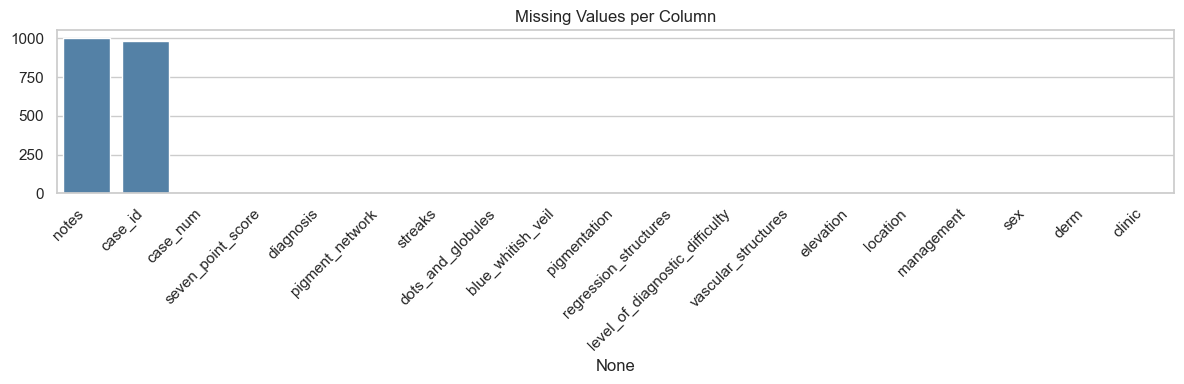

In [7]:
# Block 3: Basic column checks and missing values

print("Columns in dataset:", list(df.columns))

missing = df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "missing_count": missing,
    "missing_rate": missing / len(df)
})
missing_df.to_csv(MISSING_FILE, index=True)

plt.figure(figsize=(12,4))
sns.barplot(x=missing.index, y=missing.values, color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()



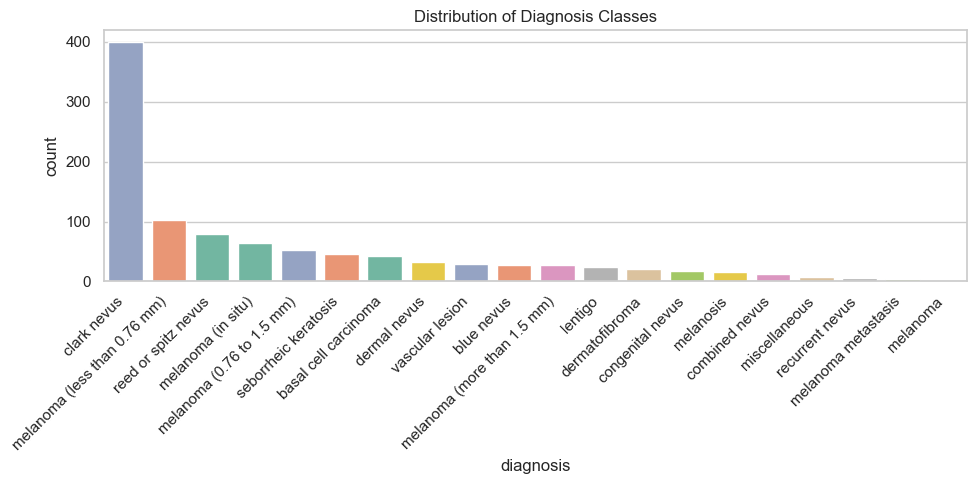

Class counts:
diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
melanoma                          1
Name: count, dtype: int64
Saved class distribution to: ../Dataset/DERM7PT\meta\class_distribution.csv


In [8]:
# Block 4: Distribution of diagnosis classes + save class distribution

plt.figure(figsize=(10,5))
sns.countplot(
    x="diagnosis",
    hue="diagnosis",
    data=df,
    order=df["diagnosis"].value_counts().index,
    palette="Set2",
    dodge=False
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Diagnosis Classes")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

print("Class counts:")
class_counts = df["diagnosis"].value_counts()
print(class_counts)

# Save class distribution to CSV for report use
class_dist_df = class_counts.reset_index()
class_dist_df.columns = ["diagnosis", "count"]
class_dist_path = os.path.join(META_DIR, "class_distribution.csv")
class_dist_df.to_csv(class_dist_path, index=False)
print(f"Saved class distribution to: {class_dist_path}")


In [9]:
# Block 5: Identify numeric and categorical features

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['case_num', 'seven_point_score']
Categorical columns: ['diagnosis', 'pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm', 'case_id', 'notes']


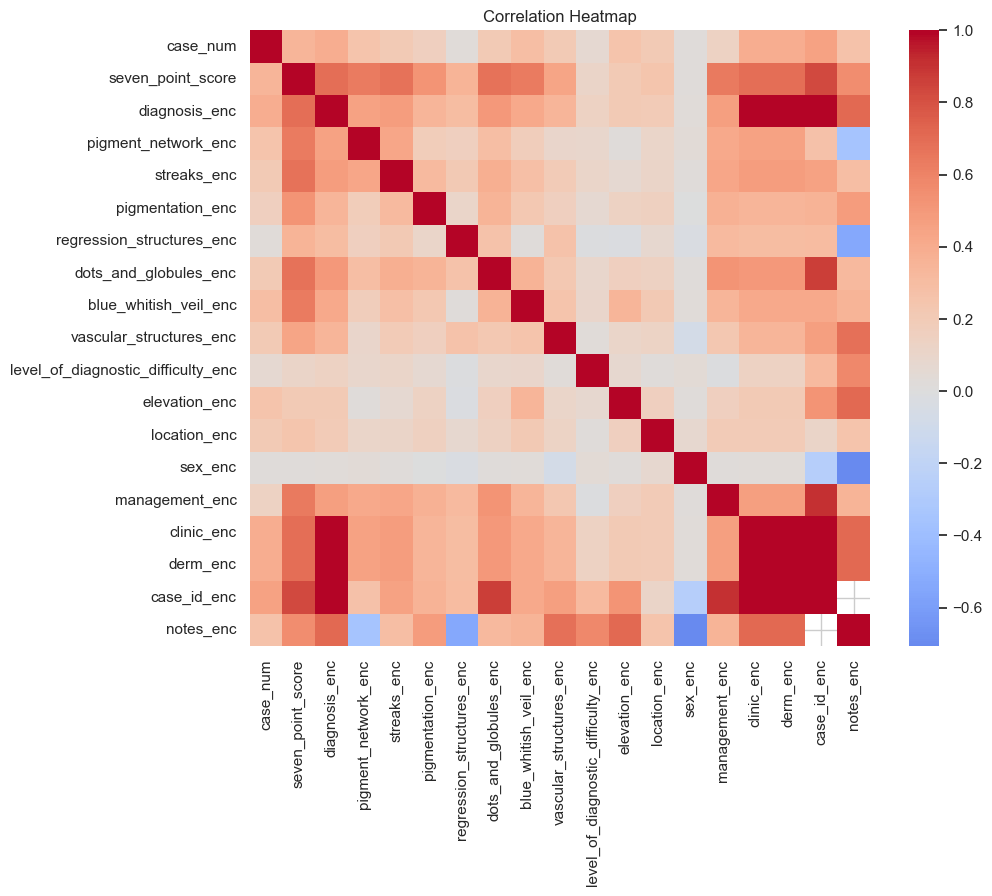

In [10]:
# Block 6: Quick correlation using target encoding for categorical columns

melanoma_labels = [
    "melanoma",
    "melanoma (less than 0.76 mm)",
    "melanoma (in situ)",
    "melanoma (0.76 to 1.5 mm)",
    "melanoma (more than 1.5 mm)",
    "melanoma metastasis"
]

df["target_binary_tmp"] = df["diagnosis"].apply(lambda x: 1 if x in melanoma_labels else 0)

for col in cat_cols:
    try:
        means = df.groupby(col)["target_binary_tmp"].mean()
        df[col + "_enc"] = df[col].map(means)
    except Exception:
        pass

num_for_corr = numeric_cols + [c for c in df.columns if c.endswith("_enc")]

corr = df[num_for_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

df.drop(columns=[c for c in df.columns if c.endswith("_enc")] + ["target_binary_tmp"], inplace=True)


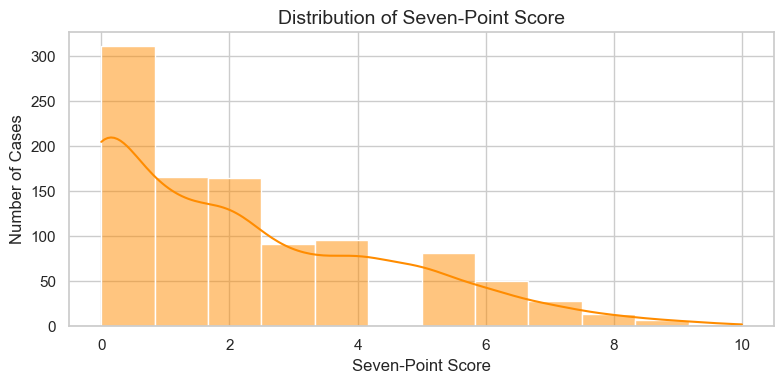

In [7]:
# Block 7: Seven-Point Score distribution
# Exploring how the diagnostic score varies across cases

if "seven_point_score" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["seven_point_score"].dropna(), bins=12, kde=True, color="darkorange")
    plt.title("Distribution of Seven-Point Score", fontsize=14)
    plt.xlabel("Seven-Point Score")
    plt.ylabel("Number of Cases")
    plt.tight_layout()
    plt.show()


Top correlations with seven_point_score:
case_id_te_tmp       0.826969
case_id_te_tmp       0.826969
clinic_te_tmp        0.687729
target_binary_tmp    0.687729
derm_te_tmp          0.687729
Name: seven_point_score, dtype: float64


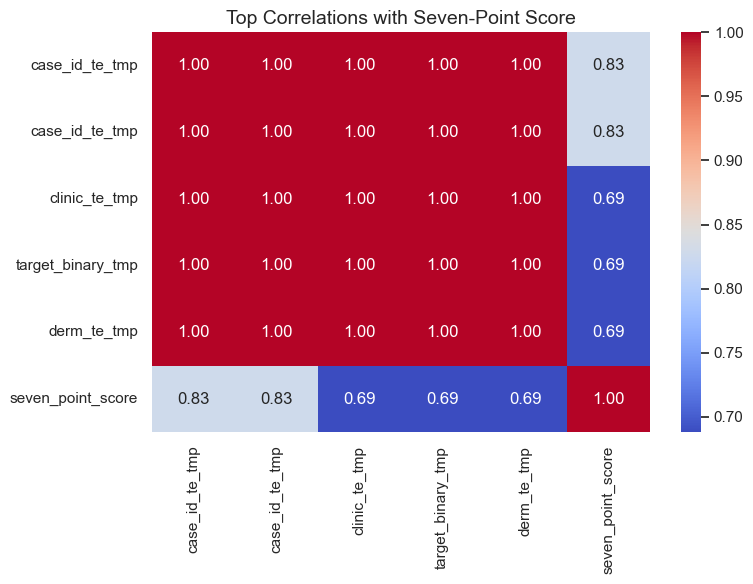

In [8]:
# Block 8: Top correlated features with seven_point_score
# Highlights which features move together with expert scoring

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != "diagnosis"]
df["target_binary_tmp"] = df["diagnosis"].fillna("").str.contains("melanoma").astype(int)

for col in categorical_cols:
    means = df.groupby(col)["target_binary_tmp"].mean()
    df[col + "_te_tmp"] = df[col].map(means)

encoded_cols = [c + "_te_tmp" for c in categorical_cols if (c + "_te_tmp") in df.columns]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
all_numeric = numeric_cols + encoded_cols

if "seven_point_score" in df.columns and all_numeric:
    corr_matrix = df[all_numeric].corr()
    if "seven_point_score" in corr_matrix.columns:
        top_corr = corr_matrix["seven_point_score"].drop("seven_point_score", errors="ignore").sort_values(ascending=False)
        print("Top correlations with seven_point_score:")
        print(top_corr.head(5))

        top_features = top_corr.head(5).index.tolist() + ["seven_point_score"]
        plt.figure(figsize=(8,6))
        sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Top Correlations with Seven-Point Score", fontsize=14)
        plt.tight_layout()
        plt.show()

df.drop(columns=[c for c in df.columns if c.endswith("_te_tmp")] + ["target_binary_tmp"], inplace=True)


In [9]:
# Block 9: Drop ID or non-predictive columns and prepare features

drop_cols = [c for c in ["case_id", "notes", "clinic", "derm", "case_num"] if c in df.columns]
df_clean = df.drop(columns=drop_cols, errors="ignore")

cat_cols = [c for c in df_clean.select_dtypes(include=["object"]).columns if c != "diagnosis"]
X = pd.get_dummies(df_clean.drop(columns=["diagnosis"]), columns=cat_cols, drop_first=True)

print("Final feature shape:", X.shape)


Final feature shape: (1011, 37)


In [10]:
# Block 10: Create binary and multiclass targets

y_binary = df_clean["diagnosis"].apply(lambda x: 1 if x in melanoma_labels else 0)
y_multiclass = pd.get_dummies(df_clean["diagnosis"])

print("Binary target distribution:")
print(y_binary.value_counts())
print("Multiclass shape:", y_multiclass.shape)


Binary target distribution:
diagnosis
0    759
1    252
Name: count, dtype: int64
Multiclass shape: (1011, 20)


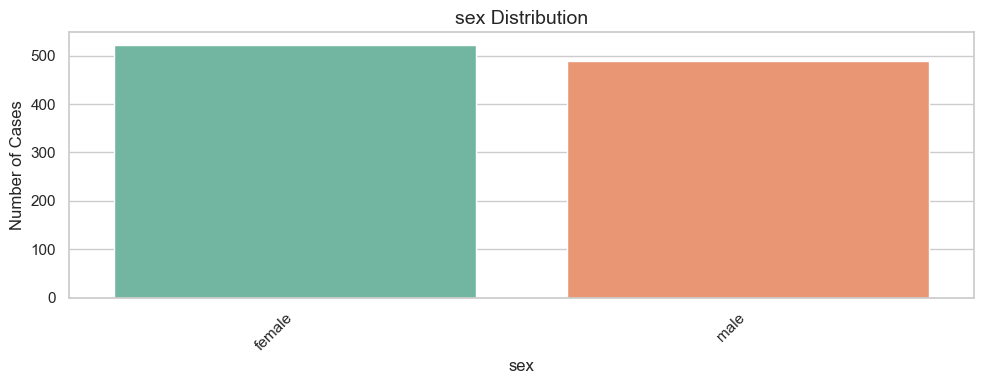

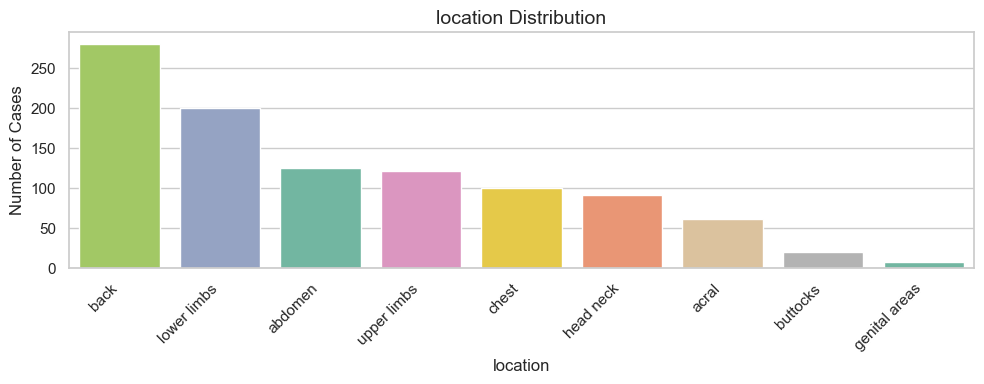

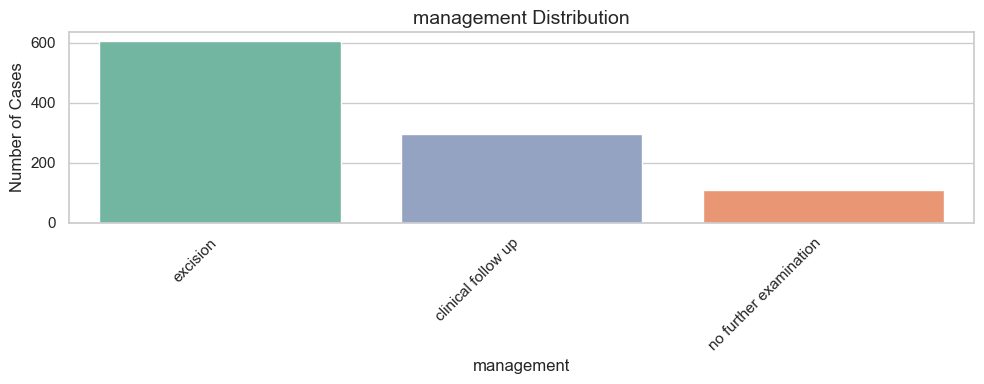

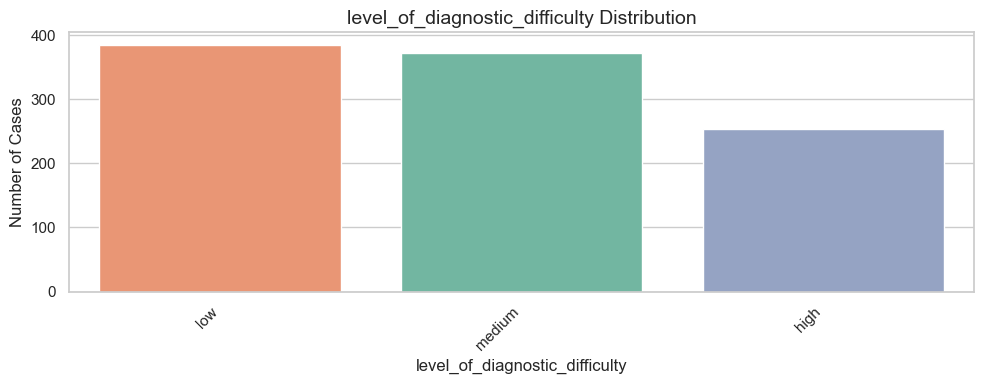

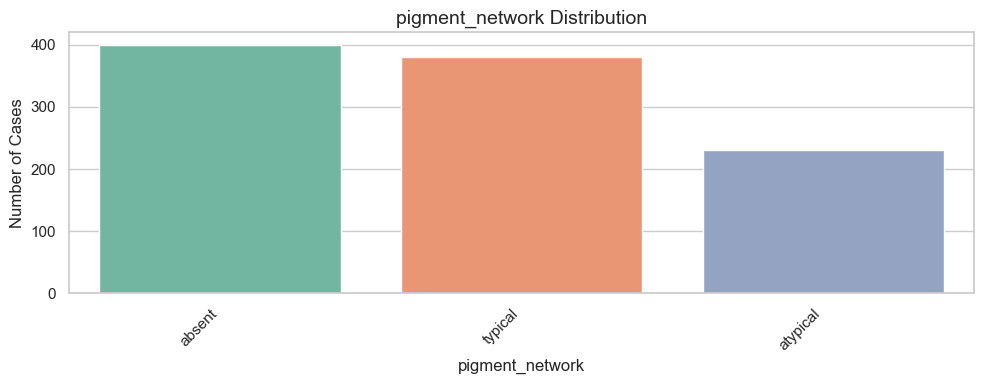

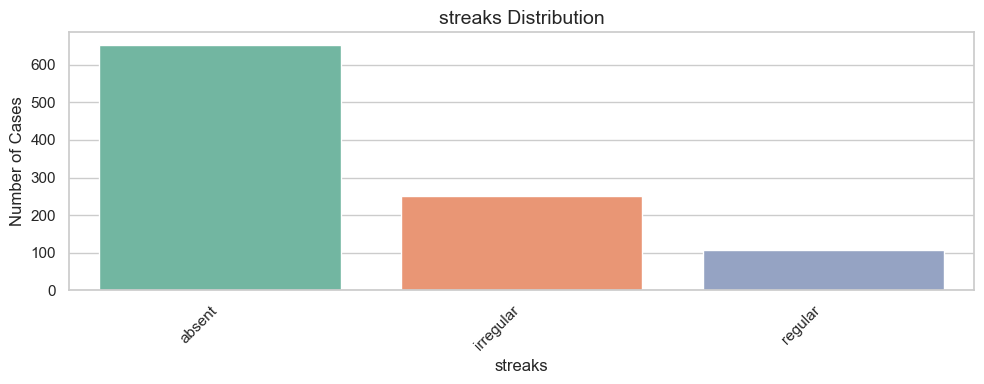

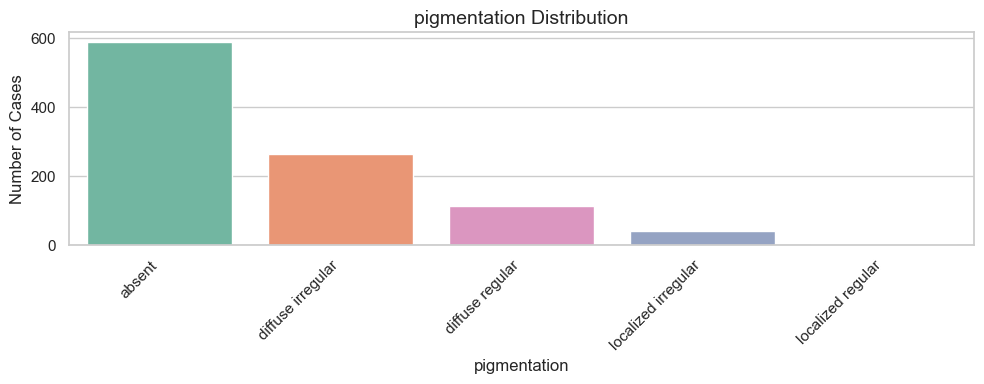

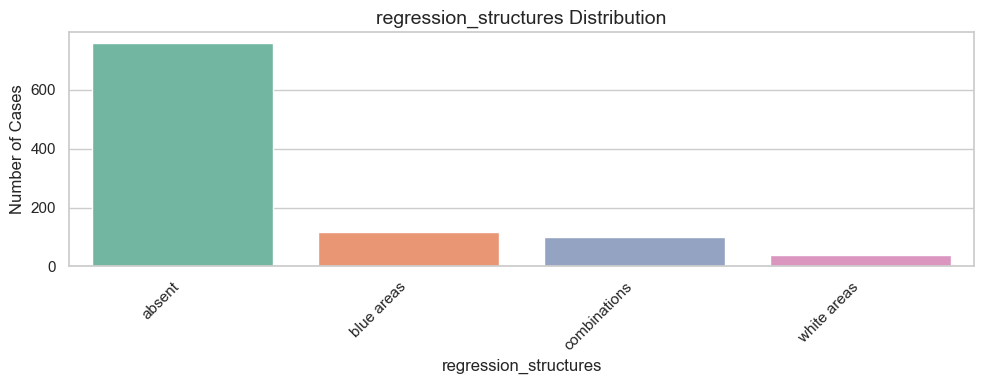

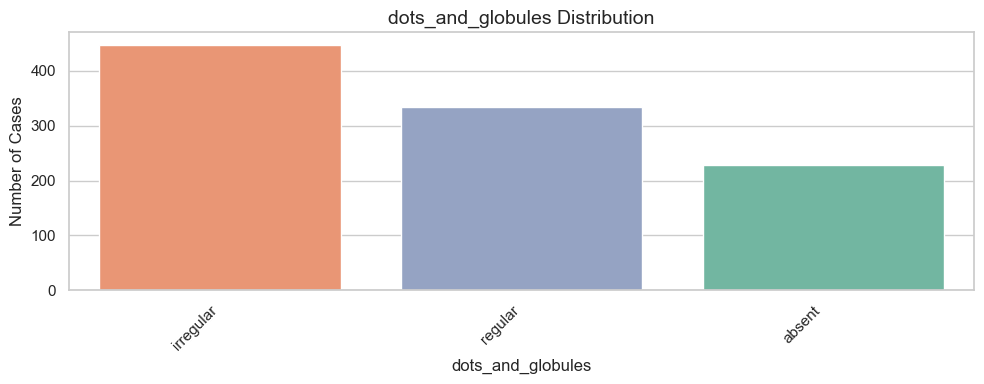

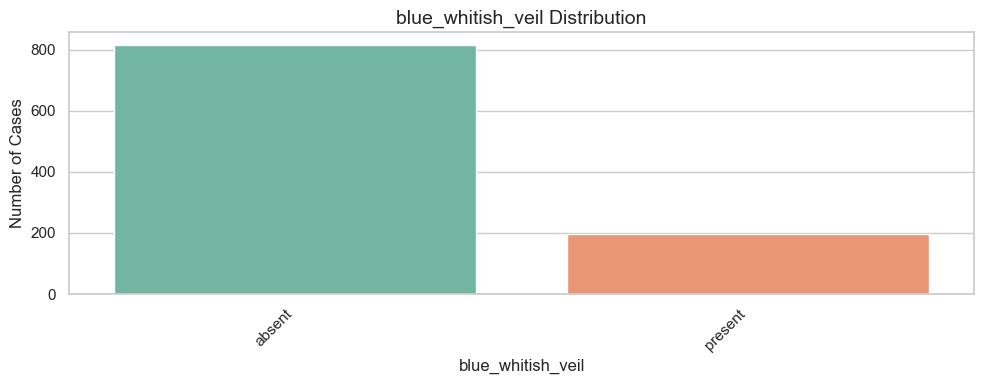

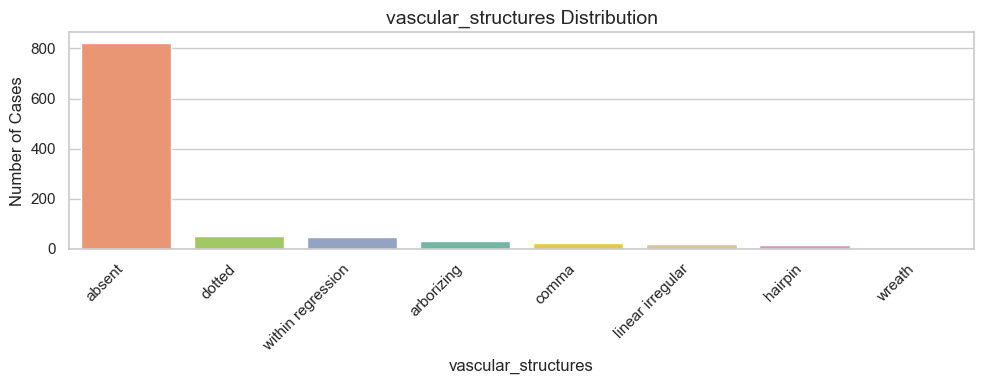

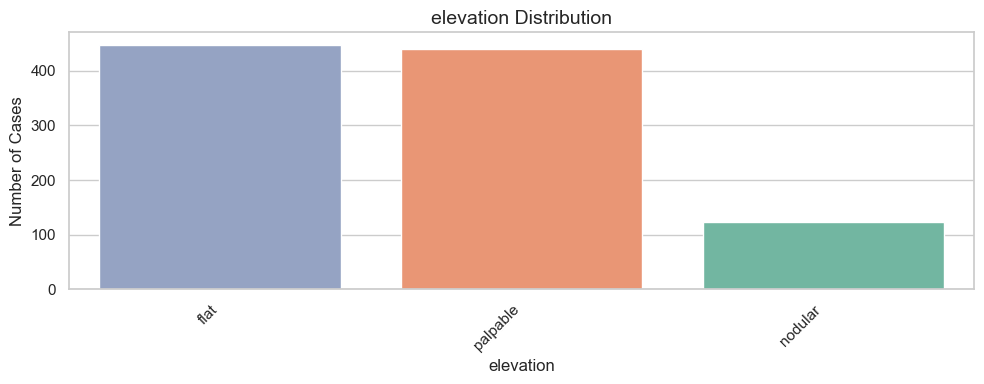

In [11]:
# Block 11: Distributions for key categorical variables
# Helps understand demographic and diagnostic feature spread

cat_to_plot = [
    "sex", "location", "management", "level_of_diagnostic_difficulty",
    "pigment_network", "streaks", "pigmentation", "regression_structures",
    "dots_and_globules", "blue_whitish_veil", "vascular_structures", "elevation"
]

for c in cat_to_plot:
    if c in df.columns:
        plt.figure(figsize=(10,4))
        order = df[c].value_counts().index
        sns.countplot(
            x=c,
            hue=c,
            data=df,
            order=order,
            palette="Set2",
            dodge=False
        )
        plt.title(f"{c} Distribution", fontsize=14)
        plt.xlabel(c)
        plt.ylabel("Number of Cases")
        plt.xticks(rotation=45, ha="right")
        plt.legend([],[], frameon=False)
        plt.tight_layout()
        plt.show()


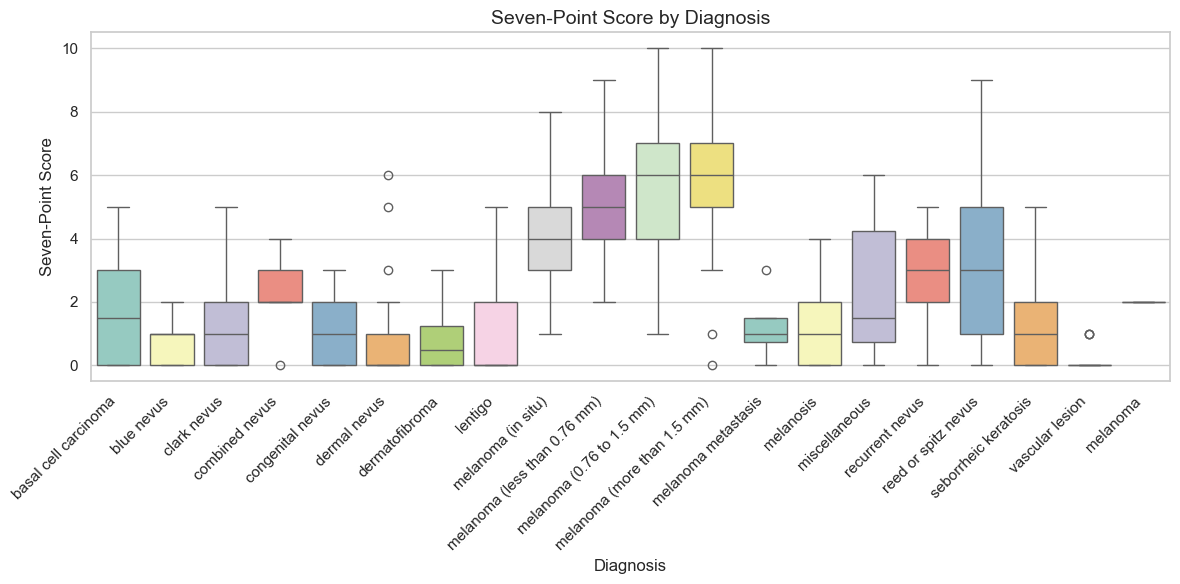

In [12]:
#  Block 12: Compare numeric score by diagnosis category
# Shows how seven_point_score differs across diagnostic classes

if "seven_point_score" in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(
        x="diagnosis",
        y="seven_point_score",
        hue="diagnosis",          # added to match palette handling
        data=df,
        palette="Set3",
        dodge=False               # ensures single box per class
    )
    plt.title("Seven-Point Score by Diagnosis", fontsize=14)
    plt.xlabel("Diagnosis")
    plt.ylabel("Seven-Point Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend([],[], frameon=False)  # hides duplicate legend
    plt.tight_layout()
    plt.show()



In [13]:
# Block 13: Standardize numeric columns (excluding IDs)

from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Scaled features. Example columns:", num_cols[:5])



Scaled features. Example columns: ['seven_point_score']


In [14]:
# Block 14: Save cleaned datasets and summary info

X.to_csv(CLEAN_FILE, index=False)
y_binary.to_frame("target_binary").to_csv(Y_BINARY_FILE, index=False)
y_multiclass.to_csv(Y_MULTI_FILE, index=False)

summary = {
    "rows": [len(df)],
    "features": [X.shape[1]],
    "numeric_features": [len(num_cols)],
    "categorical_features": [len(cat_cols)],
    "missing_columns": [(X.isna().sum() > 0).sum()]
}
pd.DataFrame(summary).to_csv(SUMMARY_FILE, index=False)

print("Saved cleaned files to meta folder.")
print("EDA complete.")


Saved cleaned files to meta folder.
EDA complete.


**Note:**  
Categorical variables (e.g., `sex`, `location`, `management`, etc.)  
will later be one-hot encoded or converted to category dtype  
during the baseline modeling phase to ensure compatibility with tabular models.


**One Hot, Mapping, and Ordinal Encoding Relative to each feature**
1. Variable mapping to 1 or 0 (e.g., `sex`, `blue_whitish_veil`)
2. One-hot encoded and converted to independent mapping
3. Display converted columns and heatmap


In [1]:
import sys

from scipy.stats import bernoulli

assert sys.version_info >= (3, 5)
# Python ≥3.5 is required

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


After filtering rare classes: 1011 samples
diagnosis
basal cell carcinoma             42
blue nevus                       28
clark nevus                     399
combined nevus                   13
congenital nevus                 17
dermal nevus                     33
dermatofibroma                   20
lentigo                          24
melanoma                          1
melanoma (0.76 to 1.5 mm)        53
melanoma (in situ)               64
melanoma (less than 0.76 mm)    102
melanoma (more than 1.5 mm)      28
melanoma metastasis               4
melanosis                        16
miscellaneous                     8
recurrent nevus                   6
reed or spitz nevus              79
seborrheic keratosis             45
vascular lesion                  29
Name: count, dtype: int64


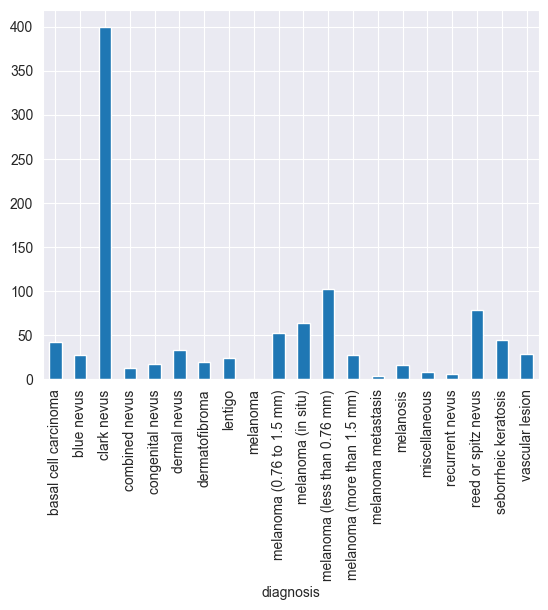

In [2]:
df = pd.read_csv('../Dataset/DERM7PT/meta/meta.csv')
print(f"\nAfter filtering rare classes: {len(df)} samples")
print(df.groupby('diagnosis')['diagnosis'].value_counts())

df.groupby('diagnosis')['diagnosis'].value_counts().plot(kind='bar')
plt.show()

In [3]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
import seaborn as sns

for column in df.columns:
    # Encoding no order categorical values as One Hot Encoder for better correlations
    if column in ['diagnosis', 'pigment_network', 'streaks', 'pigmentation', 'regression_structures',
                  'dots_and_globules', 'vascular_structures', 'elevation', 'location', 'management']:
        # coder = LabelEncoder()
        # columnCoder = coder.fit_transform(df[[column]])
        # df[column] = columnCoder
        df = pd.get_dummies(df, columns=[column])

    # Encoding yes or no type categories into binary mapping
    elif column in ['blue_whitish_veil']:
        df[column] = df[column].map({'present': 1, 'absent': 0})

    elif column in ['sex']:
        df[column] = df[column].map({'male': 1, 'female': 0})

    # Encoding ordered categorical values with Ordinal Encoding
    elif column in ['level_of_diagnostic_difficulty']:
        coder = OrdinalEncoder()
        columnCoder = coder.fit_transform(df[[column]])
        df[column] = columnCoder

new_df = df
new_df = new_df.drop(columns=['clinic', 'derm', 'case_num', 'case_id', 'notes'])
print(new_df.columns)

Index(['seven_point_score', 'blue_whitish_veil',
       'level_of_diagnostic_difficulty', 'sex',
       'diagnosis_basal cell carcinoma', 'diagnosis_blue nevus',
       'diagnosis_clark nevus', 'diagnosis_combined nevus',
       'diagnosis_congenital nevus', 'diagnosis_dermal nevus',
       'diagnosis_dermatofibroma', 'diagnosis_lentigo', 'diagnosis_melanoma',
       'diagnosis_melanoma (0.76 to 1.5 mm)', 'diagnosis_melanoma (in situ)',
       'diagnosis_melanoma (less than 0.76 mm)',
       'diagnosis_melanoma (more than 1.5 mm)',
       'diagnosis_melanoma metastasis', 'diagnosis_melanosis',
       'diagnosis_miscellaneous', 'diagnosis_recurrent nevus',
       'diagnosis_reed or spitz nevus', 'diagnosis_seborrheic keratosis',
       'diagnosis_vascular lesion', 'pigment_network_absent',
       'pigment_network_atypical', 'pigment_network_typical', 'streaks_absent',
       'streaks_irregular', 'streaks_regular', 'pigmentation_absent',
       'pigmentation_diffuse irregular', 'pigmenta

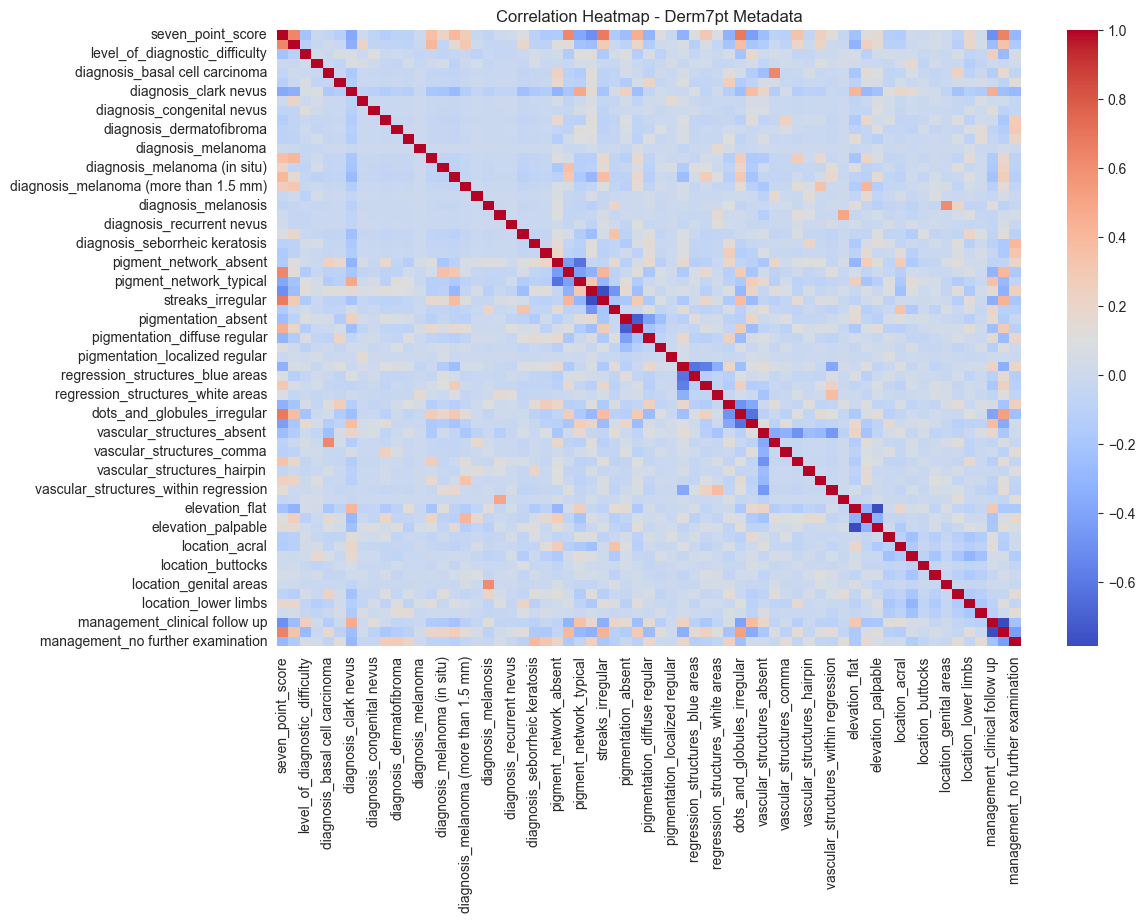

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

corr = new_df.corr()
# print(corr)

with open("output.txt", "w") as f:
    # print(corr, file=f)
    filter = (corr > 0.2) & (corr != 1)
    result = corr[filter].stack().reset_index().rename(
        columns={'level_0': 'Row', 'level_1': 'Column', 0: 'Value'}).sort_values(by="Value",
                                                                                 ascending=False).reset_index(drop=True)
    # result.columns = ['Row', 'Column','Value']
    print(result, file=f)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap - Derm7pt Metadata")
plt.show()